In [1]:
import tensorflow as tf
import os
import random
import numpy as np

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

import time

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
print(tf.__version__)

2.4.0


In [3]:
NAME = "narrow-unet-relu-output-stretched-{}".format(int(time.time()))

In [4]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [5]:
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 1

In [13]:
X_PATH = '1 mm'
Y_PATH = '0 mm'

X_data = np.zeros((180, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_data = np.zeros((180, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
X_test = np.zeros((10, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_test = np.zeros((10, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [19]:
# X_data is 1 mm
# Y_data is 0 mm
    
for i in range(10):
    img = imread(('1 mm/32p1r00' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[i] = img
    
for i in range(10,100):
    img = imread(('1 mm/32p1r0' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[i] = img
    
for i in range(10):
    img = imread(('1 mm/32p1r10' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[100+i] = img
    
for i in range (10,80):
    img = imread(('1 mm/32p1r1' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[100+i] = img
    print(100+i)
    
    
    
for i in range(10):
    img = imread(('0 mm/32p0r00' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[i] = img
    
for i in range(10,100):
    img = imread(('0 mm/32p0r0' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[i] = img
    
for i in range(10):
    img = imread(('0 mm/32p0r10' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[100+i] = img
    
for i in range (10,80):
    img = imread(('0 mm/32p0r1' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[100+i] = img
    print(100+i)
    
X_data = np.subtract(X_data,0.95)
X_data = np.multiply(X_data,10)
Y_data = np.subtract(Y_data,0.95)
Y_data = np.multiply(Y_data,10)
#X_test = np.subtract(X_test,0.95)
#X_test = np.multiply(X_test,10)
#Y_test = np.subtract(X_test,0.95)
#Y_test = np.multiply(X_test,10)

110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [20]:
X_data.shape

(180, 1024, 1024, 1)

In [29]:
TRAIN_NUM = 170
X_train = X_data[0:TRAIN_NUM]
X_test = X_data[TRAIN_NUM:]
Y_train = Y_data[0:TRAIN_NUM]
Y_test = Y_data[TRAIN_NUM:]

In [30]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(170, 1024, 1024, 1)
(10, 1024, 1024, 1)
(170, 1024, 1024, 1)
(10, 1024, 1024, 1)


In [31]:
print(X_data.shape)
print(Y_data.shape)

(180, 1024, 1024, 1)
(180, 1024, 1024, 1)


In [32]:
print(np.amax(X_data))
print(np.amin(X_data))

1.2782876491546635
-0.3325266838073726


In [33]:
print(np.amax(Y_data))
print(np.amin(Y_data))

0.5000000000000004
-0.24774026870727495


In [34]:
#X_data = np.subtract(X_data,0.95)
#X_data = np.multiply(X_data,10)

In [10]:
#Y_data = np.subtract(Y_data,0.95)
#Y_data = np.multiply(Y_data,10)

In [11]:
print(np.amax(X_data))
print(np.amin(X_data))

1.2782876491546635
-0.3325266838073726


In [12]:
print(np.amax(Y_data))
print(np.amin(Y_data))

0.5000000000000004
-0.24774026870727495


<function matplotlib.pyplot.show(*args, **kw)>

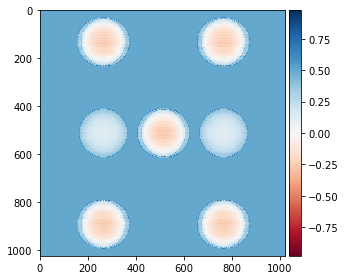

In [37]:
imshow(np.squeeze(X_train[2]))
plt.show

In [14]:
print(np.sum(Y_data))
print(100*1024*1024)

42923166.220345505
104857600


<function matplotlib.pyplot.show(*args, **kw)>

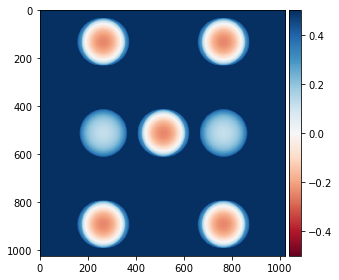

In [36]:
imshow(np.squeeze(Y_train[2]))
plt.show

In [38]:
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 1


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

#Expansive path
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='relu')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024, 1024, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 1 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1024, 1024, 1 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [40]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

In [41]:
#with tf.device("/device:GPU:0"):
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=1, epochs=3, callbacks=callbacks)
model.save(os.path.join("models", NAME))

Epoch 1/3
153/153 [==============================] - 493s 3s/step - loss: 0.0452 - root_mean_squared_error: 0.2069 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417
Epoch 2/3
153/153 [==============================] - 505s 3s/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1409
Epoch 3/3
153/153 [==============================] - 488s 3s/step - loss: 0.0259 - root_mean_squared_error: 0.1610 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1392
INFO:tensorflow:Assets written to: models/narrow-unet-relu-output-stretched-1612221054/assets


In [14]:
model = tf.keras.models.load_model('models/narrow_unet_25epochs_RMSE_relu_modified_data')

In [42]:
predict_test = model.predict(
    X_test, batch_size=None, verbose=1, steps=None, max_queue_size=10,
    workers=1, use_multiprocessing=False
)

1/1 [==============================] - 3s 3s/step


In [43]:
predict_test.shape
print(np.sum(predict_test[:,:,:]))
print(1024*1024*10)

4263736.0
10485760


<function matplotlib.pyplot.show(*args, **kw)>

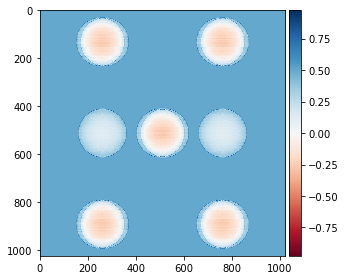

In [44]:
imshow(np.squeeze(X_test[8]))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

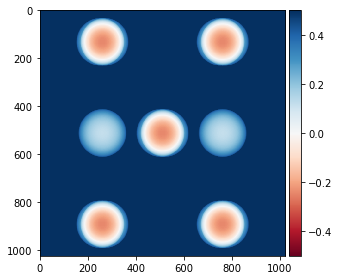

In [45]:
imshow(np.squeeze(Y_test[8]))
plt.show

/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show(*args, **kw)>

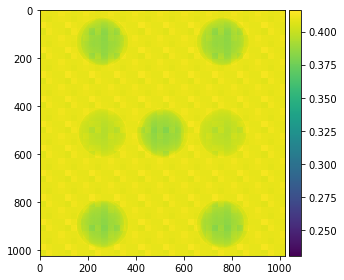

In [46]:
imshow(np.squeeze(predict_test[8]))
plt.show

In [47]:
predict_test = np.divide(predict_test,10)
predict_test = np.add(predict_test,0.95)

<function matplotlib.pyplot.show(*args, **kw)>

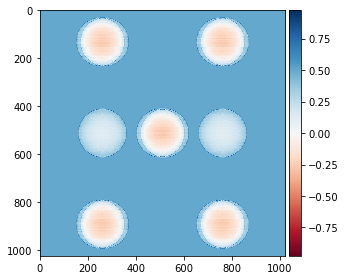

In [48]:
imshow(np.squeeze(X_test[8]))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

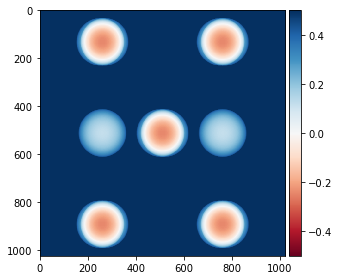

In [49]:
imshow(np.squeeze(Y_test[8]))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

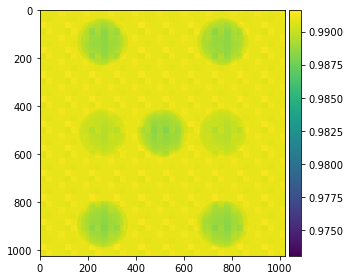

In [50]:
imshow(np.squeeze(predict_test[8]))
plt.show

In [ ]:
!tensorboard --logdir=logs/

W0202 11:31:15.901606 123145388883968 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0202 11:31:15.906001 123145388883968 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0202 11:31:15.910943 123145388883968 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0202 11:31:15.918702 123145388883968 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0202 11:31:15.922918 12

W0202 11:31:16.159161 123145388883968 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0202 11:31:16.163354 123145388883968 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0202 11:31:16.166216 123145388883968 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)
